# More Neural Network Testing

In [54]:
# Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Tensorflow aliases
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import plot_model

data = pd.read_csv('../parkinsons_updrs.csv')

# Drop the subject # column because it is useless
data = data.drop('subject#', axis=1)

X = data.drop(['motor_UPDRS', 'total_UPDRS'], axis=1)
y = data['total_UPDRS']

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_cols = list(X.drop('sex', axis=1).columns)

# create a column transformer - no need to transform target variable, just features
ct = make_column_transformer(
  (MinMaxScaler(), numeric_cols), # turn all values in these columns between 0 and 1
  (OneHotEncoder(handle_unknown='ignore'), ['sex']) 
)

# fit the column transformer to our training data
ct.fit(X_train)

# transform training and test data with normalization (MinMaxScaler) and OneHotEncoder
X_train = pd.DataFrame(ct.transform(X_train))
X_test = pd.DataFrame(ct.transform(X_test))

# Randomly select 10% of the training data to be the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Original data: {len(X)}\nTraining set: {len(X_train)}\nValidation set: {len(X_val)}\nTesting set: {len(X_test)}")

# Weight regularization to keep the weights small
def build_model(neurons, layers, input_shape, activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False):
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  if regularizer != None:
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation, kernel_regularizer=regularizer(lam)))
      if dropout:
        model.add(Dropout(drop_prob)) # randomly select nodes with probability drop_prob
  else:
    model.add(Dense(neurons, input_shape=input_shape))
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation))
      if dropout:
        model.add(Dropout(drop_prob))
  

  model.add(Dense(1))
  model.compile(loss='mae', optimizer='adam', metrics=['mae', 'mape', 'mse', tf.keras.metrics.RootMeanSquaredError()])

  if summarize:
    model.build()
    model.summary()
    
  return model

# Helper functions
def show_acc(h, e):
  plt.plot(range(e), h.history['mae'], label='Training')
  plt.plot(range(e), h.history['val_mae'], label='Validation')
  plt.ylim([0, np.max(h.history['mae'])+10])
  plt.legend()
  plt.show()

def build_and_plot(neurons, layers, input_shape, activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False, e=100, verbose=0):
  model = build_model(neurons, layers, input_shape, activation=activation, regularizer=regularizer, lam=lam, dropout=dropout, drop_prob=drop_prob, summarize=summarize)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=e, verbose=verbose)
  show_acc(history, e)
  print("Max MAE: ", np.max(history.history['mae']))
  print("Min MAE: ", np.min(history.history['mae']))
  print("Test performance ", model.evaluate(X_test, y_test))
  return model, history

Original data: 5875
Training set: 3760
Validation set: 940
Testing set: 1175


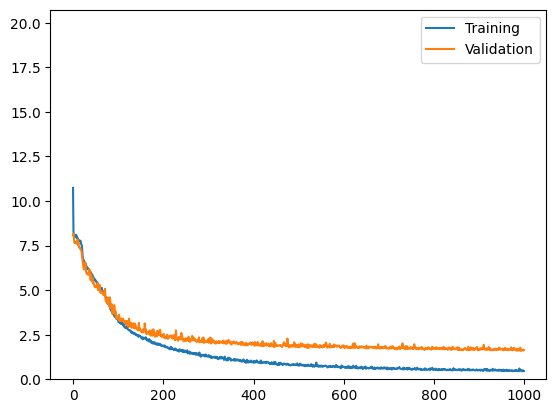

Max MAE:  10.736837387084961
Min MAE:  0.44553858041763306
37/37 [==============================] - 0s 612us/step - loss: 1.7028 - mae: 1.7028 - mape: 7.1302 - mse: 10.6360 - root_mean_squared_error: 3.2613
Test performance  [1.702829360961914, 1.702829360961914, 7.130195140838623, 10.635960578918457, 3.261281967163086]


In [55]:
# # Model 32: Without norm: 3.117 || With norm: 0.445 min, test: 1.7028
model_32, history_32 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=False, e=1000, verbose=0)


# # Model 45: 5.8274
# model_45, history_45 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.4, e=1000, verbose=0)


# # Model 44: 6.3948
# model_44, history_44 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.3, e=1000, verbose=0)


# # Model 35: 6.3388
# model_35, history_35 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, activation='elu', dropout=False, e=1000, verbose=0)


# # Model 31: 3.6883
# model_31, history_31 = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=False, e=500, verbose=0)

In [56]:
# Dropout with regularization 7.96
#model_drop_reg = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.01, activation='elu', dropout=True, e=1000, verbose=0)

## L2 regularization, no dropout

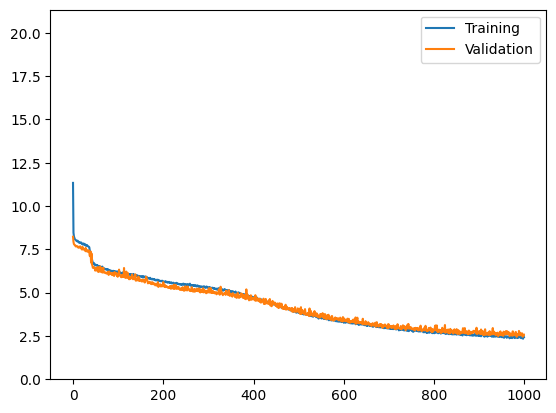

Max MAE:  11.336886405944824
Min MAE:  2.339080333709717
37/37 [==============================] - 0s 608us/step - loss: 3.5919 - mae: 2.7808 - mape: 12.3552 - mse: 21.1081 - root_mean_squared_error: 4.5944
Test performance  [3.5918617248535156, 2.780778646469116, 12.355226516723633, 21.10811424255371, 4.594357013702393]


In [57]:
l2_mod_no_drop,  l2_mod_no_drop_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.001, activation='elu', dropout=False, e=1000, verbose=0)

## L1 Regularization

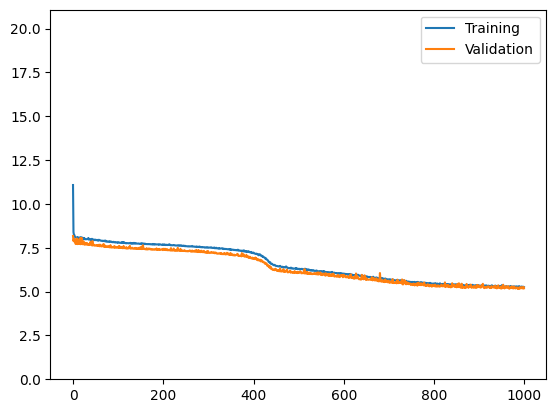

Max MAE:  11.078664779663086
Min MAE:  5.243800163269043
37/37 [==============================] - 0s 514us/step - loss: 5.5512 - mae: 5.3370 - mape: 22.3494 - mse: 57.8169 - root_mean_squared_error: 7.6037
Test performance  [5.551229476928711, 5.3370442390441895, 22.34935760498047, 57.81692886352539, 7.6037445068359375]


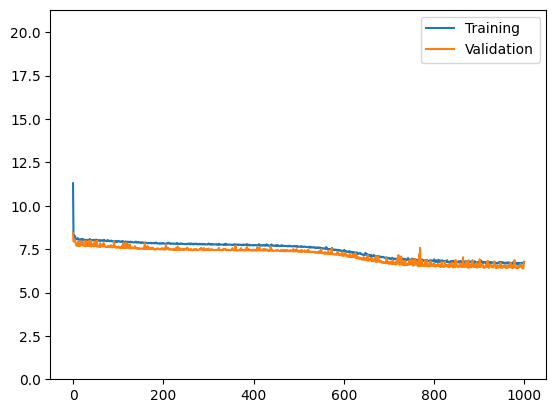

Max MAE:  11.297577857971191
Min MAE:  6.6461334228515625
37/37 [==============================] - 0s 534us/step - loss: 7.0927 - mae: 6.8305 - mape: 26.2727 - mse: 83.4197 - root_mean_squared_error: 9.1334
Test performance  [7.0926971435546875, 6.830545425415039, 26.272668838500977, 83.41974639892578, 9.133440971374512]


In [60]:
l1_001, l1_001_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l1, lam=0.001, activation='elu', dropout=False, e=1000, verbose=0)
l1_01, l1_01_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.01, activation='elu', dropout=False, e=1000, verbose=0)

## L2 regularization

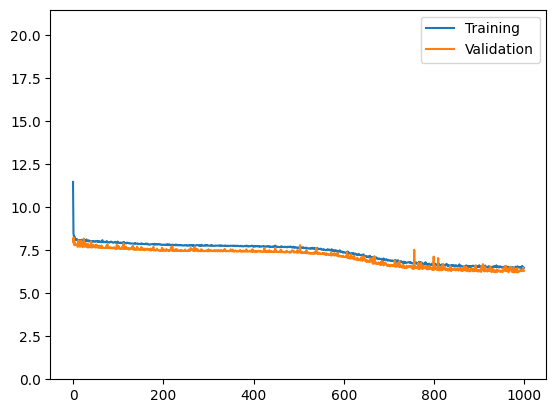

Max MAE:  11.458539009094238
Min MAE:  6.449456691741943
37/37 [==============================] - 0s 626us/step - loss: 6.7355 - mae: 6.4194 - mape: 26.9156 - mse: 72.4082 - root_mean_squared_error: 8.5093
Test performance  [6.735484600067139, 6.4194183349609375, 26.915552139282227, 72.40818786621094, 8.509300231933594]


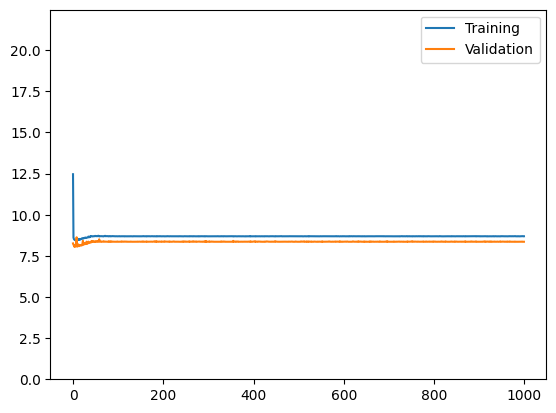

Max MAE:  12.461385726928711
Min MAE:  8.456629753112793
37/37 [==============================] - 0s 474us/step - loss: 8.4275 - mae: 8.4274 - mape: 36.6273 - mse: 112.2689 - root_mean_squared_error: 10.5957
Test performance  [8.427473068237305, 8.427358627319336, 36.62728500366211, 112.2689208984375, 10.595703125]


In [59]:
l2_01, l2_01_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.01, activation='elu', dropout=False, e=1000, verbose=0)
l2_1, l2_1_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.1, activation='elu', dropout=False, e=1000, verbose=0)

## Super weak L2

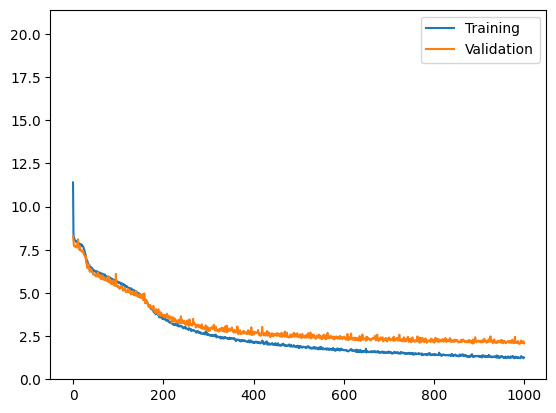

Max MAE:  11.3994140625
Min MAE:  1.2112113237380981
37/37 [==============================] - 0s 580us/step - loss: 2.4986 - mae: 2.1503 - mape: 10.2499 - mse: 14.1420 - root_mean_squared_error: 3.7606
Test performance  [2.49857497215271, 2.1503336429595947, 10.249932289123535, 14.142029762268066, 3.760589122772217]


In [61]:
l2_0001, l2_0001_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.0001, activation='elu', dropout=False, e=1000, verbose=0)

## Super weak L1

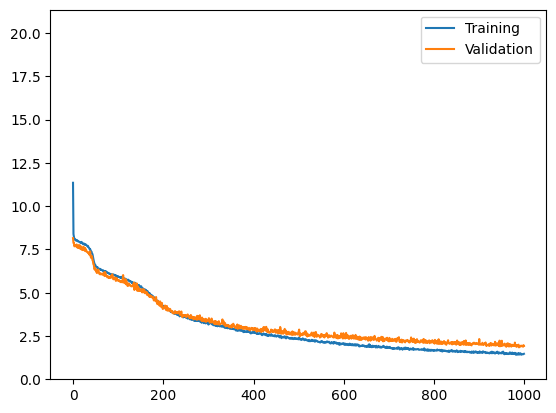

Max MAE:  11.350796699523926
Min MAE:  1.4177945852279663
37/37 [==============================] - 0s 659us/step - loss: 2.4970 - mae: 2.1119 - mape: 9.3703 - mse: 14.4551 - root_mean_squared_error: 3.8020
Test performance  [2.4970083236694336, 2.1118786334991455, 9.3703031539917, 14.455055236816406, 3.801980495452881]


In [62]:
l1_0001, l1_0001_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l1, lam=0.0001, activation='elu', dropout=False, e=1000, verbose=0)

## Extemely weak L1 and L2 Regularization

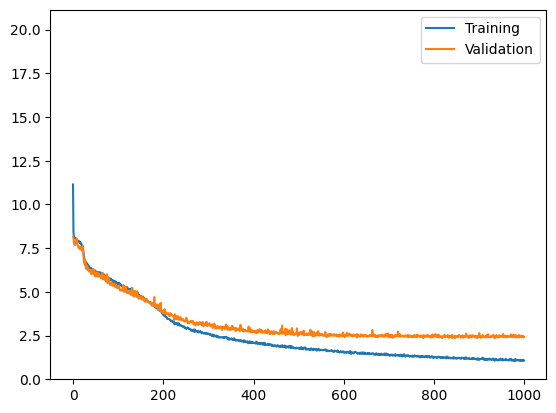

Max MAE:  11.142309188842773
Min MAE:  1.0465610027313232
37/37 [==============================] - 0s 741us/step - loss: 2.5987 - mae: 2.5278 - mape: 12.2386 - mse: 19.4328 - root_mean_squared_error: 4.4083
Test performance  [2.5987207889556885, 2.527846097946167, 12.238606452941895, 19.432844161987305, 4.408269882202148]


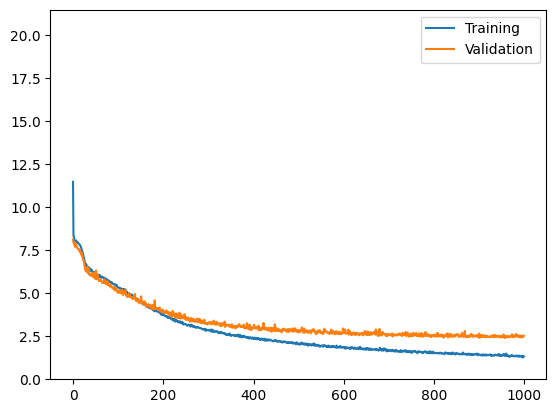

Max MAE:  11.465738296508789
Min MAE:  1.2671194076538086
37/37 [==============================] - 0s 618us/step - loss: 2.7233 - mae: 2.6288 - mape: 12.2529 - mse: 19.6048 - root_mean_squared_error: 4.4277
Test performance  [2.723334789276123, 2.6287825107574463, 12.252908706665039, 19.60478973388672, 4.427729606628418]


In [63]:
l2_00001, l2_00001_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l2, lam=0.00001, activation='elu', dropout=False, e=1000, verbose=0)
l1_00001, l1_00001_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), regularizer=l1, lam=0.00001, activation='elu', dropout=False, e=1000, verbose=0)

## Adjust Learning Rate

In [64]:
def build_and_plot_opt(neurons, layers, input_shape, optimizer='adam', activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False, e=100, verbose=0):
  model = build_model_opt(neurons, layers, input_shape, optimizer=optimizer, activation=activation, regularizer=regularizer, lam=lam, dropout=dropout, drop_prob=drop_prob, summarize=summarize)
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=e, verbose=verbose)
  show_acc(history, e)
  print("Max MAE: ", np.max(history.history['mae']))
  print("Min MAE: ", np.min(history.history['mae']))
  print("Test performance ", model.evaluate(X_test, y_test))
  return model, history

# Weight regularization to keep the weights small
def build_model_opt(neurons, layers, input_shape, optimizer='adam', activation='linear', regularizer=None, lam=0.01, dropout=False, drop_prob=0.2, summarize=False):
  model = Sequential()
  model.add(Flatten(input_shape=input_shape))
  if regularizer != None:
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation, kernel_regularizer=regularizer(lam)))
      if dropout:
        model.add(Dropout(drop_prob)) # randomly select nodes with probability drop_prob
  else:
    model.add(Dense(neurons, input_shape=input_shape))
    for i in range(layers-1):
      model.add(Dense(neurons, activation=activation))
      if dropout:
        model.add(Dropout(drop_prob))
  

  model.add(Dense(1))
  model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mape', 'mse', tf.keras.metrics.RootMeanSquaredError()])

  if summarize:
    model.build()
    model.summary()
    
  return model

## Dropout

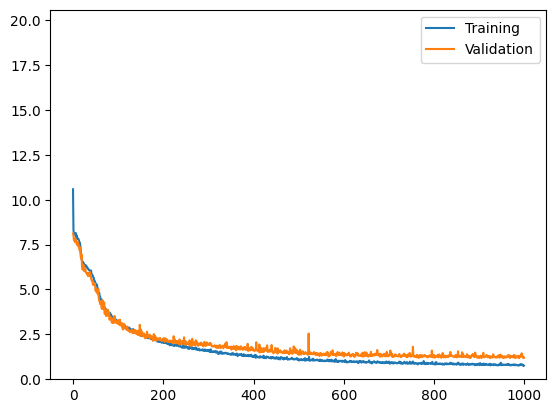

Max MAE:  10.58012580871582
Min MAE:  0.7341221570968628
37/37 [==============================] - 0s 667us/step - loss: 1.2630 - mae: 1.2630 - mape: 5.4421 - mse: 7.2772 - root_mean_squared_error: 2.6976
Test performance  [1.2629787921905518, 1.2629787921905518, 5.442068576812744, 7.2771525382995605, 2.697619676589966]


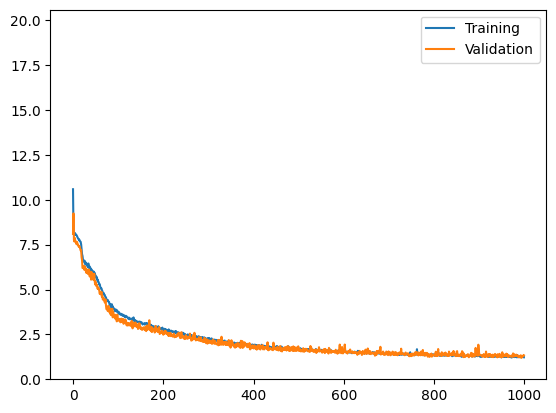

Max MAE:  10.584449768066406
Min MAE:  1.2100839614868164
37/37 [==============================] - 0s 657us/step - loss: 1.5120 - mae: 1.5120 - mape: 5.8779 - mse: 8.1709 - root_mean_squared_error: 2.8585
Test performance  [1.5119813680648804, 1.5119813680648804, 5.877908706665039, 8.170910835266113, 2.858480453491211]


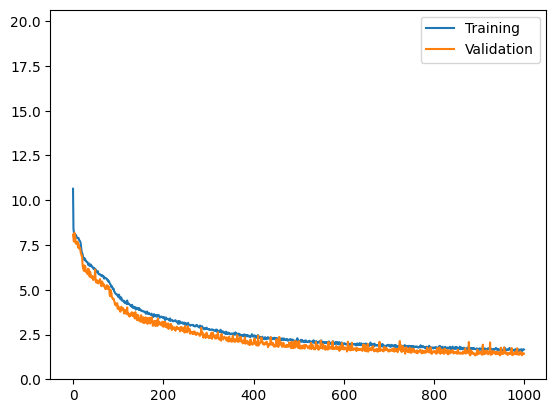

Max MAE:  10.641440391540527
Min MAE:  1.554494023323059
37/37 [==============================] - 0s 611us/step - loss: 1.5017 - mae: 1.5017 - mape: 6.0049 - mse: 9.9884 - root_mean_squared_error: 3.1604
Test performance  [1.5016601085662842, 1.5016601085662842, 6.004942893981934, 9.988428115844727, 3.160447359085083]


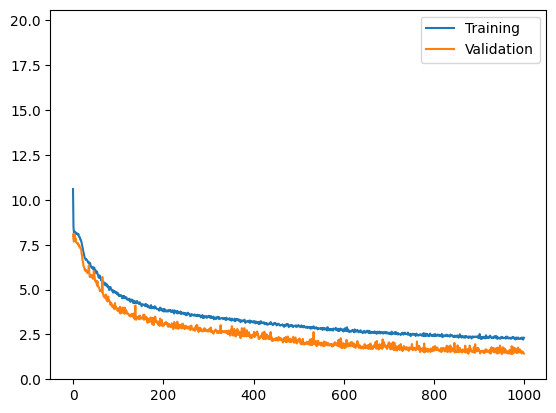

Max MAE:  10.602733612060547
Min MAE:  2.2104265689849854
37/37 [==============================] - 0s 597us/step - loss: 1.5668 - mae: 1.5668 - mape: 6.3752 - mse: 8.9514 - root_mean_squared_error: 2.9919
Test performance  [1.5667791366577148, 1.5667791366577148, 6.375197410583496, 8.951401710510254, 2.991889238357544]


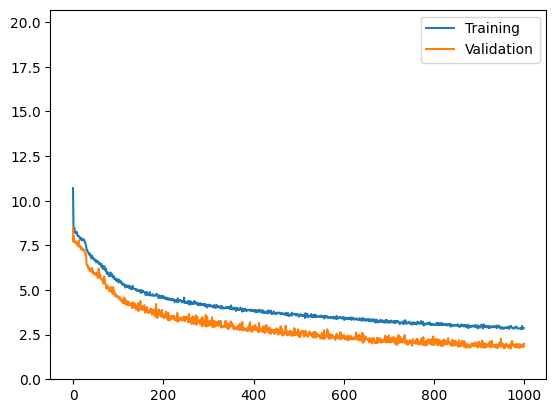

Max MAE:  10.701183319091797
Min MAE:  2.808405876159668
37/37 [==============================] - 0s 602us/step - loss: 2.1356 - mae: 2.1356 - mape: 8.7346 - mse: 14.0562 - root_mean_squared_error: 3.7492
Test performance  [2.135605812072754, 2.135605812072754, 8.734588623046875, 14.056242942810059, 3.7491655349731445]


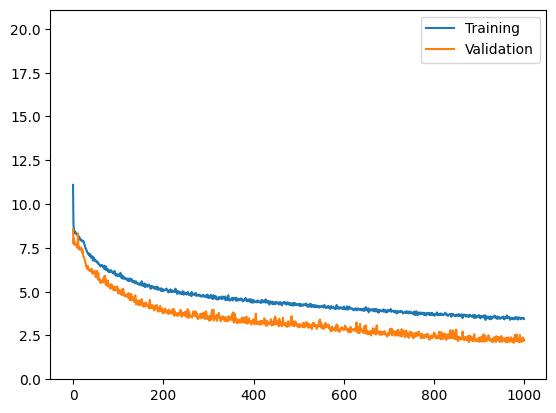

Max MAE:  11.096518516540527
Min MAE:  3.3854503631591797
37/37 [==============================] - 0s 643us/step - loss: 2.5080 - mae: 2.5080 - mape: 10.2795 - mse: 17.3596 - root_mean_squared_error: 4.1665
Test performance  [2.5080041885375977, 2.5080041885375977, 10.279547691345215, 17.359588623046875, 4.1664838790893555]


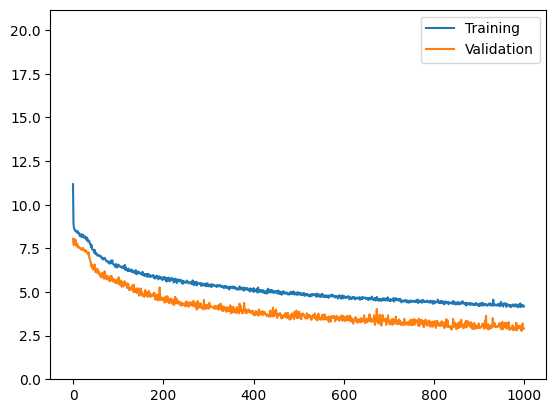

Max MAE:  11.177787780761719
Min MAE:  4.117754936218262
37/37 [==============================] - 0s 519us/step - loss: 3.1339 - mae: 3.1339 - mape: 13.9213 - mse: 26.4981 - root_mean_squared_error: 5.1476
Test performance  [3.133918523788452, 3.133918523788452, 13.921309471130371, 26.49812889099121, 5.1476335525512695]


In [66]:
drop_01, drop_01_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.01, e=1000, verbose=0)
drop_05, drop_05_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.05, e=1000, verbose=0)
drop_1, drop_1_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.1, e=1000, verbose=0)
drop_2, drop_2_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.2, e=1000, verbose=0)
drop_3, drop_3_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.3, e=1000, verbose=0)
drop_4, drop_4_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.4, e=1000, verbose=0)
drop_5, drop_5_history = build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=True, drop_prob=0.5, e=1000, verbose=0)

In [65]:
# build_and_plot(neurons=128, layers=4, input_shape=(X_train.shape[1],), activation='elu', dropout=False, e=1000, verbose=0)

In [58]:
y_test.describe()

count    1175.000000
mean       28.788817
std        10.531260
min         7.000000
25%        21.333000
50%        27.292000
75%        35.709500
max        54.992000
Name: total_UPDRS, dtype: float64